In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from x2 import X2Env
from stable_baselines3.common.env_checker import check_env

check_env(X2Env())

In [91]:
from eval import eval_model
from checkpoint import load_from_checkpoint

N = 25_000

all_rews = []

uuid = '3eccbcb1-894f-4721-810b-fd5d0279cb73'
model, offset = load_from_checkpoint(uuid)

for i in range(1, 100):
    model.learn(total_timesteps=N)
    rewards = eval_model(model)

    iters = (offset + N * (i + 1)) / 1000
    print(f'after {iters}k learning steps, mean rewards: {rewards.mean():0.2f}, std={rewards.std():0.2f}')

    model.save(f"models/{uuid}_{iters}k.model")

    all_rews.append(rewards)

Loading latest model: models/3eccbcb1-894f-4721-810b-fd5d0279cb73_100.0k.model


array([[<AxesSubplot:title={'center':'reward'}>]], dtype=object)

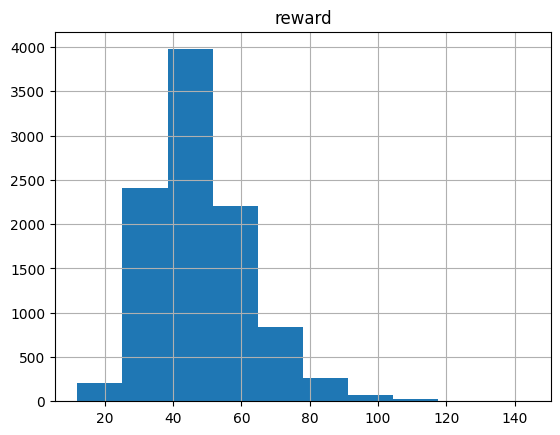

In [6]:
import pandas as pd

rewards = all_rews[-1]

df = pd.DataFrame(rewards, columns=["reward"])
df.hist()

In [7]:
import numpy as np

seed = int(np.argmax(rewards))
print(seed, print(np.max(rewards)))

env = X2Env()
state, _ = env.reset(seed=seed)

iter = 0

144
4291 None


In [76]:
from x2 import print_grid

s = env.get_state()

print_grid(s.grid)

action, _ = model.predict(state, deterministic=True)

print(f"iter: {iter}, next: {s.next_play} action: {action}")

next_state, reward, done, _, _ = env.step(action)

print_grid(s.grid)
iter += 1

0009 0008 0004 0001 0004
0008 0005 0001 0007 0005
0007 ---- 0003 0004 0006
---- ---- 0002 ---- ----
---- ---- ---- ---- ----
iter: 68, next: 3 action: 3
0009 0008 0004 0001 0004
0008 0005 0001 0007 0005
0007 ---- 0003 0004 0006
---- ---- 0002 0003 ----
---- ---- ---- ---- ----
